In [15]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests

import ipywidgets as widgets
from ipydatagrid import DataGrid, TextRenderer
from IPython.display import display,Markdown
from IPython.display import HTML

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance,variance_decomposition_ex_post,diversification_constraint,create_constraint
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

from scipy.stats import norm, chi2,gumbel_l

In [17]:
def display_scrollable_df(df, max_height="50vh", max_width="90vw"):
    style = f"""
    <div style="
        display: flex;
        justify-content: center;
        padding: 20px;
    ">
        <div style="
            overflow: auto;
            max-height: {max_height};
            max-width: {max_width};
            width: 100%;
            border: 1px solid #444;
            padding: 10px;
            background-color: #000;
            color: #eee;
            font-family: 'Arial Narrow', Arial, sans-serif;
            box-sizing: border-box;
        ">
            {df.to_html(classes='table', border=0, index=True)}
        </div>
    </div>
    """
    return HTML(style)

def build_constraint(prices, constraint_matrix):
    constraints = []
    dico_map = {'=': 'eq', '≥': 'ineq', '≤': 'ineq'}

    drop_down_list_asset = list(prices.columns) + ['All']
    drop_down_list = drop_down_list_asset + [None]

    try:
        for row in range(constraint_matrix.shape[0]):
            temp = constraint_matrix[row, :]
            ticker = temp[0]

            if ticker not in drop_down_list:
                continue

            sign = temp[1]
            limit = float(temp[2])

            if ticker == 'All':
                constraint = diversification_constraint(sign, limit)

            elif ticker in drop_down_list_asset:
                position = np.where(prices.columns == ticker)[0][0]
                constraint = create_constraint(sign, limit, position)

            constraints.extend(constraint)

    except Exception as e:
        print(f"Error in build_constraint: {e}")

    return constraints

    
def get_expected_metrics(returns,dataframe):
    portfolio=RiskAnalysis(returns)
    allocation_dict={}

    for idx in dataframe.index:
        allocation_dict[idx]=dataframe.loc[idx].to_numpy()


    
    metrics={}
    metrics['Expected Returns']={}
    metrics['Expected Volatility']={}
    metrics['Sharpe Ratio']={}

    for key in allocation_dict:

        metrics['Expected Returns'][key]=(np.round(portfolio.performance(allocation_dict[key]), 4))
        metrics['Expected Volatility'][key]=(np.round(portfolio.variance(allocation_dict[key]), 4))
        sharpe_ratio=np.round(portfolio.performance(allocation_dict[key])/portfolio.variance(allocation_dict[key]),2)
        metrics['Sharpe Ratio'][key]=sharpe_ratio

    indicators = pd.DataFrame(metrics,index=allocation_dict.keys())

    return indicators.T.round(4)
def rebalanced_time_series(prices,dataframe,frequency='Monthly'):

    portfolio_returns=pd.DataFrame()

    for key in dataframe.index:
        portfolio_returns['Buy and Hold '+key]=buy_and_hold(prices, dataframe.loc[key]).sum(axis=1)
        portfolio_returns['Rebalanced '+key]=rebalanced_portfolio(prices, dataframe.loc[key],frequency=frequency).sum(axis=1)

    portfolio_returns.index.name='Date'
    
    return portfolio_returns

def rebalanced_metrics(portfolio_returns):

    ret=portfolio_returns.iloc[-1]/portfolio_returns.iloc[0]-1
    ytd=(1+ret)**(365/(portfolio_returns.index[-1]-portfolio_returns.index[0]).days)-1
    ret_ytd=portfolio_returns.loc[datetime.datetime(max(portfolio_returns.index.year),1,1):].iloc[-1]/portfolio_returns.loc[datetime.datetime(max(portfolio_returns.index.year),1,1):].iloc[0]-1

    perfs=pd.concat([ret,ret_ytd,ytd],axis=1)
    perfs.columns=['Returns since '+ pd.to_datetime(portfolio_returns.index[0], format='%Y-%d-%m').strftime("%Y-%m-%d"),
              'Returns since '+datetime.datetime(max(portfolio_returns.index.year), 1, 1).strftime("%Y-%m-%d"),
              'Annualized Returns']
    
    return perfs.T.round(4)

    
def get_portfolio_risk(dataframe,prices,portfolio_returns,benchmark):

    allocation_dict={}
    
    returns=prices.pct_change()
    
    for idx in dataframe.index:
        allocation_dict[idx]=dataframe.loc[idx].to_numpy()


    tracking_error_daily={}
    tracking_error_monthly={}
    monthly_returns=prices.resample('ME').last().iloc[-180:].pct_change()


    for key in allocation_dict:
        if key not in allocation_dict or benchmark not in allocation_dict:
            continue

        tracking_error_daily['Buy and Hold '+key]=RiskAnalysis(returns).variance(allocation_dict[key]-allocation_dict[benchmark])/np.sqrt(252)*np.sqrt(260)
        tracking_error_daily['Rebalanced '+key]=RiskAnalysis(returns).variance(allocation_dict[key]-allocation_dict[benchmark])/np.sqrt(252)*np.sqrt(260)
        tracking_error_monthly['Buy and Hold '+key]=RiskAnalysis(monthly_returns).variance(allocation_dict[key]-allocation_dict[benchmark])/np.sqrt(252)*np.sqrt(12)
        tracking_error_monthly['Rebalanced '+key]=RiskAnalysis(monthly_returns).variance(allocation_dict[key]-allocation_dict[benchmark])/np.sqrt(252)*np.sqrt(12)

 
            
    tracking_error_daily=pd.DataFrame(tracking_error_daily.values(),index=tracking_error_daily.keys(),columns=['Tracking Error (daily)'])
    tracking_error_monthly=pd.DataFrame(tracking_error_monthly.values(),index=tracking_error_monthly.keys(),columns=['Tracking Error (Monthly)'])

    dates_drawdown=((portfolio_returns-portfolio_returns.cummax())/portfolio_returns.cummax()).idxmin().dt.date
    
    vol=portfolio_returns.pct_change().iloc[:].std()*np.sqrt(260)
    monthly_vol=portfolio_returns.resample('ME').last().iloc[:].pct_change().std()*np.sqrt(12)

    drawdown=pd.DataFrame((((portfolio_returns-portfolio_returns.cummax()))/portfolio_returns.cummax()).min())
    Q=0.05
    intervals=np.arange(Q, 1, 0.0005, dtype=float)
    cvar=monthly_vol*norm(loc =0 , scale = 1).ppf(1-intervals).mean()/0.05

    risk=pd.concat([vol,tracking_error_daily,monthly_vol,tracking_error_monthly,cvar,drawdown,dates_drawdown],axis=1).round(4)
    risk.columns=['Annualized Volatility (daily)','TEV (daily)',
                  'Annualized Volatility (Monthly)','TEV (Monthly)',
                  'CVar Parametric '+str(int((1-Q)*100))+'%',
                  'Max Drawdown','Date of Max Drawdown']
    
    return risk.T.round(4)
    
def get_asset_returns(prices):
    
    ret=prices.iloc[-1]/prices.iloc[0]-1
    ytd=(1+ret)**(365/(prices.index[-1]-prices.index[0]).days)-1
    ret_ytd=prices.loc[datetime.datetime(max(prices.index.year), 1, 1):].iloc[-1]/prices.loc[datetime.datetime(max(prices.index.year),1,1):].iloc[0]-1

    perfs=pd.concat([ret,ret_ytd,ytd],axis=1)
    perfs.columns=['Returns since '+ pd.to_datetime(prices.index[0], format='%Y-%d-%m').strftime("%Y-%m-%d"),
              'Returns since '+datetime.datetime(max(prices.index.year), 1, 1).strftime("%Y-%m-%d"),
              'Annualized Returns']
    
    return perfs.T.round(4)

def get_asset_risk(prices):

    dates_drawdown=((prices-prices.cummax())/prices.cummax()).idxmin().dt.date
    
    vol=prices.pct_change().iloc[-260:].std()*np.sqrt(260)
    weekly_vol=prices.resample('W').last().iloc[-153:].pct_change().std()*np.sqrt(52)
    monthly_vol_1Y=prices.resample('ME').last().iloc[-50:].pct_change().std()*np.sqrt(12)
    monthly_vol_5Y=prices.resample('ME').last().iloc[-181:].pct_change().std()*np.sqrt(12)

    drawdown=pd.DataFrame((((prices-prices.cummax()))/prices.cummax()).min())
    Q=0.05
    intervals=np.arange(Q, 1, 0.0005, dtype=float)
    cvar=monthly_vol_5Y*norm(loc =0 , scale = 1).ppf(1-intervals).mean()/0.05

    risk=pd.concat([vol,weekly_vol,monthly_vol_1Y,monthly_vol_5Y,cvar,drawdown,dates_drawdown],axis=1).round(4)
    risk.columns=['Annualized Volatility (daily)',
    'Annualized Volatility 3Y (Weekly)',
    'Annualized Volatility 5Y (Monthly)','Annualized Volatility since '+str(prices.index[0].year) +' (Monthly)',
    'CVar Parametric '+str(int((1-Q)*100))+'%','Max Drawdown','Date of Max Drawdown']
    
    
    return risk.T.round(4)

def get_yearly_metrics(portfolio_returns,fund='Fund',bench='Bitcoin'):
    
    portfolio_returns=portfolio_returns[[fund,bench]]
    years=sorted(list(set(portfolio_returns.index.year)))
    portfolio_returns_pct=portfolio_returns.pct_change()
    
    year_returns={}
    year_vol={}
    year_tracking_error={}
    year_sharpe_ratio={}
    
    for year in years:
        temp=portfolio_returns_pct.loc[str(year)]
        year_vol[year]=temp.std()*np.sqrt(252)
    
        temp_2=temp.copy()
    
        for col in temp_2.columns:
            temp_2[col]=temp_2[col]-temp[bench]
            
        year_tracking_error[year]=temp_2.std()*np.sqrt(252)
        perf_year=portfolio_returns.loc[str(year)].iloc[-1]/portfolio_returns.loc[str(year)].iloc[0]-1
        year_sharpe_ratio[year]=perf_year/(temp.std()*np.sqrt(252))
        year_returns[year]=perf_year
        
    
    year_returns_dataframe=pd.DataFrame(year_returns).round(4)
    year_vol_dataframe=pd.DataFrame(year_vol).round(4)
    year_tracking_error_dataframe=pd.DataFrame(year_tracking_error.values(),index=year_tracking_error.keys()).round(4)
    year_sharpe_ratio_dataframe=pd.DataFrame(year_sharpe_ratio).round(4)

    return year_returns_dataframe,year_vol_dataframe,year_tracking_error_dataframe,year_sharpe_ratio_dataframe

def get_monthly_metrics(portfolio_returns,fund='Fund',bench='Bitcoin'):
    
    portfolio_returns=portfolio_returns[[fund,bench]]
    portfolio_returns_pct=portfolio_returns.pct_change()
    
    month_returns={}
    month_vol={}
    month_tracking_error={}
    month_sharpe_ratio={}
    
    month_year=portfolio_returns.index.strftime('%Y-%m')
    month_year=sorted(list(set(month_year)))
    
    for month in month_year:
        temp=portfolio_returns_pct.loc[str(month)]
        month_vol[month]=temp.std()*np.sqrt(252)
    
        temp_2=temp.copy()
    
        for col in temp_2.columns:
            temp_2[col]=temp_2[col]-temp[bench]
            
        month_tracking_error[month]=temp_2.std()*np.sqrt(252)
        perf_month=portfolio_returns.loc[str(month)].iloc[-1]/portfolio_returns.loc[str(month)].iloc[0]-1
        month_sharpe_ratio[month]=perf_month/(temp.std()*np.sqrt(252))
        month_returns[month]=perf_month
        
    
    month_returns_dataframe=pd.DataFrame(month_returns).round(4)
    month_vol_dataframe=pd.DataFrame(month_vol).round(4)
    month_tracking_error_dataframe=pd.DataFrame(month_tracking_error.values(),index=month_tracking_error.keys()).round(4)
    month_sharpe_ratio_dataframe=pd.DataFrame(month_sharpe_ratio).round(4)

    return month_returns_dataframe,month_vol_dataframe,month_tracking_error_dataframe,month_sharpe_ratio_dataframe

def get_calendar_graph(performance_fund,fund='Fund',benchmark='Bitcoin',freq='Year'):

    if freq=='Year':
        metrics = get_yearly_metrics(performance_fund,fund=fund,bench=benchmark)
    else:
        metrics = get_monthly_metrics(performance_fund,fund=fund,bench=benchmark)
        
    titles = [
        f"Returns by {freq}",
        f"Volatility by {freq}",
        f"Tracking Error by {freq}",
        f"Sharpe Ratio by {freq}"
    ]
    
    for i, title in enumerate(titles):
        if title!=f"Tracking Error by {freq}":
            df = metrics[i].T  # <-- no transpose
            fig = px.bar(
                df,
                x=df.index,  # years on x-axis
                y=df.columns,
                barmode="group",
                title=title,
                labels={"value": "Value", "variable": "Asset", "x": "Year"}
            )
    
            fig.update_layout(
                plot_bgcolor="black",
                paper_bgcolor="black",
                font_color="white",
                title_font=dict(size=20),
                legend=dict(title="Legend")
            )
    
            fig.update_traces(
                textfont=dict(family="Arial Narrow", size=15),
                hovertemplate="Year: %{x}<br>%{y:.3f}<extra></extra>")

            
            fig.show()

        else:
            
            df = metrics[i]
            fig = px.bar(df, x=df.index, y=df.columns,
                         barmode="group",  # use "overlay" to overlap instead
                         title=f"Tracking Error by {freq}",
                         labels={"value": "Value", "Year": "Year", "variable": "Asset"})
            
            # fig.update_layout(xaxis=dict(dtick=1))
            fig.update_layout(
                plot_bgcolor="black",
                paper_bgcolor="black",
                font_color="white",
                title_font=dict(size=20),
                legend=dict(title="Legend")
            )            
            
            fig.update_traces(
                textfont=dict(family="Arial Narrow", size=15),
                hovertemplate="Year: %{x}<br>%{y:.3f}<extra></extra>")
            fig.show()
def get_frontier(returns,dataframe):
    portfolio=RiskAnalysis(returns)
    frontier_weights, frontier_returns, frontier_risks, frontier_sharpe_ratio = portfolio.efficient_frontier()
    
    weight_matrix={}

    for idx in dataframe.index:
        
        weight_matrix[idx]=dataframe.loc[idx].to_numpy()
    
    metrics = {
        'Returns': {},
        'Volatility': {},
        'Sharpe Ratio': {}
    }
    for key in weight_matrix:
        
        metrics['Returns'][key]=(np.round(portfolio.performance(weight_matrix[key]), 4))
        metrics['Volatility'][key]=(np.round(portfolio.variance(weight_matrix[key]), 4))
        metrics['Sharpe Ratio'][key]=np.round(metrics['Returns'][key]/metrics['Volatility'][key],4)
    
    
    frontier = pd.DataFrame(
        {
            "Returns": frontier_returns,
            "Volatility": frontier_risks,
            "Sharpe Ratio": frontier_sharpe_ratio,
        }
    )
    
    fig = px.scatter(
        frontier,
        y="Returns",
        x="Volatility",
        color="Sharpe Ratio",
        color_continuous_scale='blues',
    )
    
    for key in weight_matrix:
    
        fig.add_scatter(
            x=[metrics["Volatility"][key]],
            y=[metrics["Returns"][key]],
            mode="markers",
            marker=dict(color="orange", size=8, symbol="x"),
            name=key,
        )
        
        
    fig.add_scatter(
        x=[metrics["Volatility"]['Optimal Portfolio']],
        y=[metrics["Returns"]['Optimal Portfolio']],
        mode="markers",
        marker=dict(color="red", size=8, symbol="x"),
        name='Optimal Portfolio',
    )
    
    fig.update_layout(
        showlegend=False, 
        hoverlabel_namelength=-1,
        font=dict(
            family="Arial Narrow",
            size=14,
            color="white" 
        ),
        plot_bgcolor="black", 
        paper_bgcolor="black"  
    )
    
    fig.update_layout(showlegend=False)
    fig.update_layout(hoverlabel_namelength=-1)
    indicators = pd.DataFrame(metrics,index=weight_matrix.keys()).T

    return indicators,fig

In [19]:
def display_crypto_app():

    # --- strategy dictionary ---
    dico_strategies = {
        'Minimum Variance': 'minimum_variance',
        'Risk Parity': 'risk_parity',
        'Sharpe Ratio': 'sharpe_ratio'
    }
    
    options_strat = list(dico_strategies.keys())

    # --- globals ---
    global tickers_dataframe, tickers, dataframe, returns_to_use, prices
    global rolling_optimization, performance_pct, performance_fund, dates_end,quantities,cumulative_results
    global book_cost,realized_pnl,profit_and_loss,holding_tickers,current_weights,fund_names,grid

    tickers_dataframe = pd.DataFrame()
    tickers = []
    holding_tickers=[]
    dataframe = pd.DataFrame()
    cumulative_results=pd.DataFrame()
    fund_names=[]
    
    current_weights=pd.DataFrame()
    book_cost=pd.DataFrame()
    realized_pnl=pd.DataFrame()
    profit_and_loss=pd.DataFrame()
    returns_to_use = pd.DataFrame()
    prices = pd.DataFrame()
    
    rolling_optimization = pd.DataFrame()
    quantities=pd.DataFrame()
    
    performance_pct = pd.DataFrame()
    performance_fund = pd.DataFrame()
    
    dates_end = []
    constraint_container = {'constraints': [], 'allocation_df': pd.DataFrame()}

    # --- UI setup ---
    start_date = widgets.DatePicker(
        value=datetime.date(2020, 1, 1),
        description='Starting Date of Backtest',
        style={'description_width': '200px'},
        layout=widgets.Layout(width='350px')
    )

    n_crypto = widgets.IntSlider(
        min=1, max=100, value=20,
        description='Number of Crypto',
        style={'description_width': '200px'},
        layout=widgets.Layout(width='500px')
    )

    data_button = widgets.Button(description='Get Prices', button_style='info')
    scope_output = widgets.Output()
    strategy_output = widgets.Output()
    main_output = widgets.Output()
    output_returns = widgets.Output()
    constraint_output = widgets.Output()
    
    dropdown_asset1 = widgets.Dropdown(description='Asset 1',style={'description_width': '150px'})
    dropdown_asset2 = widgets.Dropdown(description='Asset 2',style={'description_width': '150px'} ) 
    # --- helper: update crypto scope ---
    def scope_update(n):
        nonlocal scope_output
        global tickers_dataframe, tickers
        try:
            tickers_dataframe = Binance.get_market_cap().iloc[:n].set_index('Ticker')
            tickers = list(tickers_dataframe.index)
        except Exception as e:
            with scope_output:
                scope_output.clear_output(wait=True)
                print("Error fetching market caps:", e)
            return
        with scope_output:
            scope_output.clear_output(wait=True)
            display(display_scrollable_df(tickers_dataframe))

    scope_update(n_crypto.value)
    n_crypto.observe(lambda ch: scope_update(ch['new']) if ch['name'] == 'value' else None, names='value')
    
    price_output=widgets.Output()
    # --- price fetching ---
    def get_prices(_=None):
        global prices, dataframe, returns_to_use, dates_end,valid_cols_model
        
        get_holdings(None)
        combined_tickers=sorted(list(set(tickers+holding_tickers)))
        
        with main_output:
            main_output.clear_output(wait=True)
            if not tickers:
                print("No tickers available. Please fetch tickers first.")
                return

            start = start_date.value
            if not isinstance(start, datetime.date):
                print("Please select a valid start date.")
                return

            today = datetime.date.today()
            days_total = (today - start).days
            if days_total <= 0:
                print("Start date must be in the past.")
                return

            remaining = days_total % 500
            numbers_of_table = days_total // 500
            temp_end = datetime.datetime.combine(start, datetime.time())
            scope_prices = pd.DataFrame()

            try:
                for _ in range(numbers_of_table + 1):
                    data = Binance.get_price(combined_tickers, temp_end)
                    temp_end += datetime.timedelta(days=500)
                    scope_prices = scope_prices.combine_first(data)

                temp_end = datetime.datetime.combine(today - datetime.timedelta(days=remaining), datetime.time())
                data = Binance.get_price(combined_tickers, temp_end)
                scope_prices = scope_prices.combine_first(data)

                scope_prices = scope_prices.sort_index()
                scope_prices = scope_prices[~scope_prices.index.duplicated(keep='first')]
                scope_prices.index = pd.to_datetime(scope_prices.index)
                prices = scope_prices.loc[:, scope_prices.columns != 'USDCUSDT']

                returns = np.log(1 + prices.pct_change(fill_method=None))
                returns.index = pd.to_datetime(returns.index)
                valid_cols = returns.columns[returns.isna().sum() < 30]

                returns_to_use = returns[valid_cols].sort_index()
                dataframe = prices[valid_cols].sort_index().dropna()
                dataframe.index = pd.to_datetime(dataframe.index)
                returns_to_use = returns_to_use[~returns_to_use.index.duplicated(keep='first')]

                dropdown_asset.options = list(dataframe.columns) + ['All']
                
                dropdown_asset1.options=dataframe.columns
                dropdown_asset1.value=dataframe.columns[0]
        
                dropdown_asset2.options=dataframe.columns
                dropdown_asset2.value=dataframe.columns[1]
                
                print(f"✅ Loaded prices for {len(dataframe.columns)} assets from {dataframe.index[0].date()} to {dataframe.index[-1].date()}")
                
                asset_risk=get_asset_risk(dataframe)
                asset_returns=get_asset_returns(dataframe)
                display(display_scrollable_df(asset_returns))
                display(display_scrollable_df(asset_risk))

            except Exception as e:
                print("Error fetching prices:", e)
                
            with price_output:
                price_output.clear_output(wait=True)
                display(display_scrollable_df(dataframe))


                
    data_button.on_click(get_prices)
    start_date.observe(lambda ch: get_prices() if ch['name'] == 'value' and ch['new'] else None, names='value')
    

    # --- constraint UI ---
    dropdown_asset = widgets.Dropdown(description='Asset:', options=['All'], value=None)
    dropdown_sign = widgets.Dropdown(description='Sign:', options=["=", "≥", "≤"])
    dropdown_limit = widgets.FloatText(description='Limit')
    add_constraint_btn = widgets.Button(description='Add Constraint', button_style='success')
    clear_constraints_btn = widgets.Button(description='Clear All', button_style='danger')
    constraints = []
    
    
    selected_fund = widgets.Dropdown(description="Fund:")
    selected_bench = widgets.Dropdown(description="Bench:")
    selected_fund_var = widgets.Dropdown(description="Fund:")
    
    def on_add_constraint_clicked(_):
        constraints.append({
            'Asset': dropdown_asset.value,
            'Sign': dropdown_sign.value,
            'Limit': dropdown_limit.value
        })
        with constraint_output:
            constraint_output.clear_output(wait=True)
            display(display_scrollable_df(pd.DataFrame(constraints)))

    def on_clear_constraints(_):
        constraints.clear()
        with constraint_output:
            constraint_output.clear_output(wait=True)
            display(display_scrollable_df(pd.DataFrame(columns=['Asset', 'Sign', 'Limit'])))

    add_constraint_btn.on_click(on_add_constraint_clicked)
    clear_constraints_btn.on_click(on_clear_constraints)
    
    def on_add_click(b):
        
        global fund_names,grid

        if grid.data is None or grid.data.empty:
            return
        new_row = np.zeros(dataframe.shape[1])
        label = f"Allocation {grid.data.shape[0]}"
        new_df = pd.DataFrame([new_row], columns=grid.data.columns, index=[label])
        updated_df = pd.concat([pd.DataFrame(grid.data), new_df])
        grid.data = updated_df
        
        benchmark_tracking_error.options=grid.data.index
        
        selected_fund.options=grid.data.index

        selected_bench.options=grid.data.index

        
        selected_fund_var.options=grid.data.index

    def clear_allocation(b):
        
        nonlocal constraint_container
        if constraint_container.get('allocation_df') is not None:
            grid.data = constraint_container['allocation_df']
            
    button_add = widgets.Button(description="Add Allocation")    
    button_clear = widgets.Button(description="Clear Allocation")            
    button_add.on_click(on_add_click)
    button_clear.on_click(clear_allocation)
    
    # --- date pickers for performance ---
    if isinstance(start_date.value, datetime.date):
        sd = start_date.value
        start_perf_date = datetime.date(sd.year, sd.month + 2, 1)
    else:
        start_perf_date = datetime.date.today() - datetime.timedelta(days=365)

    start_date_perf = widgets.DatePicker(value=start_perf_date, layout=widgets.Layout(width='350px'))
    end_date_perf = widgets.DatePicker(value=datetime.date.today(), layout=widgets.Layout(width='350px'))
    
    frequency_graph=widgets.Dropdown(description='Frequency:', options=['Year','Month'], value='Year')
    benchmark=widgets.Dropdown(description='Benchmark:', options=['Fund','Bitcoin'], value='Bitcoin')
    fund=widgets.Dropdown(description='Fund:', options=['Fund','Bitcoin'], value='Fund')
    benchmark_tracking_error=widgets.Dropdown(description='Benchmark:')

    perf_output=widgets.Output()
    vol_output=widgets.Output()
    drawdown_output=widgets.Output()
    frontier_output=widgets.Output()
    
    # --- performance update ---
    def updated_cumulative_perf(_):
        global performance_pct, performance_fund,cumulative_results

        try:
            start_ts = pd.to_datetime(start_date_perf.value)
            end_ts = pd.to_datetime(end_date_perf.value)
        except Exception:
            with output_returns:
                output_returns.clear_output(wait=True)
                print("⚠️ Invalid start/end dates.")
            return
            
        with main_output:
            
            main_output.clear_output(wait=True)
            range_prices=dataframe.loc[start_ts:end_ts]
            range_returns=range_prices.pct_change()
            
            asset_risk=get_asset_risk(range_prices)
            asset_returns=get_asset_returns(range_prices)
            display(display_scrollable_df(asset_returns))
            display(display_scrollable_df(asset_risk))

        if performance_pct is None or performance_pct.empty:
            with output_returns:
                output_returns.clear_output(wait=True)
                print("⚠️ No performance data available yet. Please run an optimization first.")
            return

        performance_pct.index = pd.to_datetime(performance_pct.index)


        if pd.isna(start_ts) or pd.isna(end_ts) or start_ts > end_ts:
            with output_returns:
                output_returns.clear_output(wait=True)
                print("⚠️ Invalid date range.")
            return

        cumulative_performance = performance_pct.loc[start_ts:end_ts]

        if cumulative_performance.empty:
            available_start = performance_pct.index.min().date()
            available_end = performance_pct.index.max().date()
            with output_returns:
                output_returns.clear_output(wait=True)
                print(f"⚠️ No data found for this date range. Available range: {available_start} → {available_end}")
            return

        cumulative_performance = cumulative_performance.copy()
        cumulative_performance.iloc[0] = 0
        cumulative_results = (1 + cumulative_performance).cumprod() * 100
        portfolio_returns = rebalanced_time_series(range_prices, grid.data, frequency=rebalancing_frequency.value)
        cumulative_results=pd.concat([cumulative_results,portfolio_returns],axis=1)

                
        drawdown = (cumulative_results - cumulative_results.cummax()) / cumulative_results.cummax()
        rolling_vol_ptf=cumulative_results.pct_change().rolling(window_vol.value).std()*np.sqrt(260)
        frontier_indicators, fig4 = get_frontier(range_returns, grid.data)
        update_dropdown_options()
        

        with output_returns:
            output_returns.clear_output(wait=True)
            display(display_scrollable_df(rebalanced_metrics(cumulative_results)))
            display(display_scrollable_df(get_portfolio_risk(grid.data, range_prices, cumulative_results, benchmark_tracking_error.value)))
            display(display_scrollable_df(frontier_indicators))

        with perf_output:
            
            perf_output.clear_output(wait=True)
            fig = px.line(cumulative_results, title='Performance', width=800, height=400)
            fig.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white")
            fig.update_traces(visible="legendonly", selector=lambda t: not t.name in ["Fund","Bitcoin"])
            fig.update_traces(textfont=dict(family="Arial Narrow", size=15))

            fig.show()
        with drawdown_output:
            
            drawdown_output.clear_output(wait=True)

            fig2 = px.line(drawdown, title='Drawdown', width=800, height=400)
            fig2.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white")
            fig2.update_traces(visible="legendonly", selector=lambda t: not t.name in ["Fund","Bitcoin"])
            fig2.update_traces(textfont=dict(family="Arial Narrow", size=15))

            fig2.show()

        with vol_output:
            vol_output.clear_output(wait=True)

            fig3 = px.line(rolling_vol_ptf, title="Portfolio Rolling Volatility").update_traces(visible="legendonly", selector=lambda t: not t.name in ["Fund","Bitcoin"])
            fig3.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white", width=800, height=400) 
            fig3.update_traces(visible="legendonly", selector=lambda t: not t.name in ["Fund","Bitcoin"])
            fig3.update_traces(textfont=dict(family="Arial Narrow", size=15))

            fig3.show()
        with frontier_output:
            frontier_output.clear_output(wait=True)

            fig4.update_layout(width=800, height=400,title={'text': "Efficient Frontier"})
            fig4.update_traces(textfont=dict(family="Arial Narrow", size=15))

            fig4.show()
            # display(display_scrollable_df(cumulative_results))
            # display(display_scrollable_df(drawdown))

        
    start_date_perf.observe(updated_cumulative_perf)
    end_date_perf.observe(updated_cumulative_perf)
    # --- optimization ---
    rebalancing_frequency = widgets.Dropdown(description='Frequency', options=['Monthly', 'Quarterly', 'Yearly'], value='Monthly')
    strat = widgets.Dropdown(description='Strategy', options=options_strat, value='Minimum Variance')
    window_vol=widgets.IntText(
    value=30,
    description='Vol Window:',
    disabled=False
    )    
    calendar_output=widgets.Output()
    def show_graph(_):
        with calendar_output:

            calendar_output.clear_output(wait=True)

            if fund.value==benchmark.value:
                print("⚠️ Benchmark and Fund must be different.")
                return
            if cumulative_results.empty:
                print("⚠️ No performance data available yet. Please run an optimization first.")
                return
            get_calendar_graph(cumulative_results, 
                               freq=frequency_graph.value, 
                               benchmark=benchmark.value, 
                               fund=fund.value)
                
                    
    graph_button=widgets.Button(description='Update Perf',button_style='info')
    graph_button.on_click(show_graph)

    optimize_btn = widgets.Button(description='Optimize Portfolio', button_style='primary')
    grid = DataGrid(pd.DataFrame(), editable=True, layout={"height": "250px"})
    

    def update_dropdown_options():
        """Safely refresh fund/benchmark dropdowns after cumulative_results is updated."""
        if 'cumulative_results' not in globals() or cumulative_results.empty:
            return

        global fund_names
        
        options = list(cumulative_results.columns)
    
        # Fund options exclude the currently selected benchmark
    
        fund.options = options
        benchmark.options = options
        
        fund.value = options[0]
        benchmark.value = options[1]
        fund_names=list(grid.data.index)
        benchmark_tracking_error.options=grid.data.index

        selected_fund.options=grid.data.index

        selected_bench.options=grid.data.index

        
        selected_fund_var.options=grid.data.index
        
    def on_optimize_clicked(_):
        global fund_names,grid

        with constraint_output:
            constraint_output.clear_output(wait=True)
            if dataframe.empty or returns_to_use.empty:
                print("⚠️ Load price data before optimizing.")
                return
            constraint_df = pd.DataFrame(constraints)
            cons = None
            if not constraint_df.empty:
                try:
                    cons = build_constraint(dataframe, constraint_df.to_numpy())
                except Exception as e:
                    print("Error building constraints:", e)
                    
            portfolio = RiskAnalysis(returns_to_use.loc[start_date_perf.value:end_date_perf.value])
            sharpe = portfolio.optimize("sharpe_ratio")
            minvar = portfolio.optimize("minimum_variance")
            rp = portfolio.optimize("risk_parity")
            sharpe_c = minvar_c = rp_c = None
    
            if cons is not None:
                sharpe_c = portfolio.optimize("sharpe_ratio", constraints=cons)
                minvar_c = portfolio.optimize("minimum_variance", constraints=cons)
                rp_c = portfolio.optimize("risk_parity", constraints=cons)
    
            allocation = {
                'Optimal Portfolio': sharpe.tolist(),
                'Constrained Optimal Portfolio': sharpe_c.tolist() if sharpe_c is not None else sharpe.tolist(),
                'Min Variance': minvar.tolist(),
                'Constrained Min Var': minvar_c.tolist() if minvar_c is not None else minvar.tolist(),
                'Risk Parity': rp.tolist(),
                'Constrained RP': rp_c.tolist() if rp_c is not None else rp.tolist()}
            
            allocation_df = pd.DataFrame(allocation, index=dataframe.columns).T.round(4)
            if set(current_weights.index).issubset(dataframe.columns):
                allocation_df = allocation_df.combine_first(current_weights.T).fillna(0)
            
            constraint_container = {'constraints': constraints, 'allocation_df': allocation_df}
            grid.data = allocation_df
            
            benchmark_tracking_error.options=grid.data.index
            benchmark_tracking_error.value=grid.data.index[0]

            selected_fund.options=grid.data.index
            selected_fund.value=grid.data.index[0]
    
            selected_bench.options=grid.data.index
            selected_bench.value=grid.data.index[0]
    
            
            selected_fund_var.options=grid.data.index
            selected_fund_var.value=grid.data.index[0]
            
            with constraint_output:
                constraint_output.clear_output(wait=True)
                display(display_scrollable_df(pd.DataFrame(constraints))) 

    def get_result(_):
        
        nonlocal constraint_container
        global rolling_optimization, performance_pct, performance_fund, dates_end,quantities
        
        with strategy_output:
            strategy_output.clear_output(wait=True)
            if dataframe.empty or returns_to_use.empty:
                print("⚠️ Load price data before optimizing.")
                return

            constraint_df = pd.DataFrame(constraints)
            cons = None
            if not constraint_df.empty:
                try:
                    cons = build_constraint(dataframe, constraint_df.to_numpy())
                except Exception as e:
                    print("Error building constraints:", e)
            
            freq_map = {
                'Monthly': pd.offsets.BMonthEnd(),
                'Quarterly': pd.offsets.BQuarterEnd(),
                'Yearly': pd.offsets.BYearEnd()
            }
            offset = freq_map.get(rebalancing_frequency.value, pd.offsets.BMonthEnd())
            candidate_anchors = pd.DatetimeIndex(sorted(set(dataframe.index + offset)))
            if candidate_anchors.empty:
                candidate_anchors = pd.DatetimeIndex([returns_to_use.index[-1]])

            idx = returns_to_use.index.get_indexer(candidate_anchors, method='nearest')
            idx = np.array(idx)
            idx = idx[idx >= 0]
            selected_dates = returns_to_use.index[idx].tolist()
            selected_dates = sorted(list(set(selected_dates + [returns_to_use.index[-1]])))
            dates_end = selected_dates

            if len(dates_end) < 2:
                print("⚠️ Not enough anchor dates to perform rolling optimization.")
                return

            results = {}
            for i in range(len(dates_end) - 1):
                subset = returns_to_use.loc[dates_end[i]:dates_end[i + 1]]
                if subset.empty or len(subset) < 2:
                    continue
                try:
                    risk = RiskAnalysis(subset)
                    opt = risk.optimize(objective=dico_strategies[strat.value], constraints=cons) if cons else \
                          risk.optimize(objective=dico_strategies[strat.value])
                    results[subset.index[-1]] = np.round(opt, 6)
                except Exception:
                    continue

            if not results:
                print("⚠️ No valid optimizations computed.")
                return

            rolling_optimization = pd.DataFrame(results, index=dataframe.columns).T.sort_index()
            if not rolling_optimization.empty and len(dataframe.columns) > 0:
                first_row = pd.Series(1 / len(dataframe.columns), index=dataframe.columns, name=dates_end[0])
                rolling_optimization = pd.concat([pd.DataFrame([first_row]), rolling_optimization])
            display(display_scrollable_df(rolling_optimization))

            quantities = rebalanced_dynamic_quantities(dataframe, rolling_optimization)
            performance_fund = pd.DataFrame({'Fund': (quantities * dataframe).sum(axis=1)})
            if 'BTCUSDT' in dataframe.columns:
                performance_fund['Bitcoin'] = dataframe['BTCUSDT']
            performance_pct = performance_fund.pct_change(fill_method=None)
            
            cumulative=(1+performance_pct).cumprod()*100
            drawdown=pd.DataFrame((cumulative-cumulative.cummax()))/cumulative.cummax()            
            date_drawdown=drawdown.idxmin().dt.date
            max_drawdown=drawdown.min()
            
            metrics={}
            metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['Bitcoin']).std()*np.sqrt(252)
            metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
            metrics['Bitcoin Vol']=performance_pct['Bitcoin'].std()*np.sqrt(252)
            metrics['Fund Return']=performance_fund['Fund'].iloc[-2]/performance_fund['Fund'].iloc[0]
            metrics['Bitcoin Return']=performance_fund['Bitcoin'].iloc[-2]/performance_fund['Bitcoin'].iloc[0]
            metrics['Sharpe Ratio']=(1+metrics['Fund Return'])**(1/len(set(returns_to_use.index.year)))/metrics['Fund Vol']
            metrics['Bitcoin Sharpe Ratio']=(1+metrics['Bitcoin Return'])**(1/len(set(returns_to_use.index.year)))/metrics['Bitcoin Vol']

            metrics['Fund Drawdown']=max_drawdown['Fund']
            metrics['Bitcoin Drawdown']=max_drawdown['Bitcoin']
            
            metrics['Fund Date Drawdown']=date_drawdown['Fund']
            metrics['Bitcoin Date Drawdown']=date_drawdown['Bitcoin']
            
            indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
            # show results
            display(display_scrollable_df(indicators.round(4)))
            updated_cumulative_perf(None)
            show_graph(None)
            get_holdings(None)
            
    optimize_btn.on_click(on_optimize_clicked)
    results_button=widgets.Button(description='Get Results',button_style='info')
    results_button.on_click(get_result)

    positions_output=widgets.Output()
    holding_output=widgets.Output()
    
    def get_holdings(_):

        global holding_tickers,current_weights,pnl
        
        quantities_api=Binance.binance_api.user_asset()
        current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
        current_quantities['asset']=current_quantities['asset']+'USDT'
        current_quantities=current_quantities.set_index('asset')
        
        current_positions=Binance.get_inventory().round(4)
        current_positions.columns=['Current Portfolio in USDT','Current Weights']
        amount=current_positions.loc['Total']['Current Portfolio in USDT']
        condition=current_positions.index!='Total'

        holding_tickers=current_positions.index[condition]
        holding_tickers=holding_tickers.to_list()
        
        inventory_weights=(current_positions['Current Weights'].apply(lambda x: np.round(x,4))).to_dict()
        inventory_weights.pop('Total')
        inventory_weights.pop('USDCUSDT')
        
        if "USDTUSDT" in holding_tickers:
            inventory_weights.pop('USDTUSDT')
        else: 
            pass
            
        current_weights=pd.DataFrame(inventory_weights.values(),index=inventory_weights.keys(),columns=['Current Weights'])
                
        with positions_output:
            positions_output.clear_output(wait=True)
        
            if dataframe.empty or returns_to_use.empty:
                print("⚠️ Load Prices.")
                # display(display_scrollable_df(current_positions))
        
            elif quantities.empty:
                print("⚠️ Load Model.")
                # display(display_scrollable_df(current_positions))
        
            else:
                last_prices = Binance.get_price(list(quantities.iloc[-1].keys()))
                positions = pd.DataFrame(quantities.iloc[-1] * last_prices).T
        
                amount_ex_out_of_positions = (
                    current_positions.loc[
                        ~(current_positions.index.isin(positions.index) | (current_positions.index == 'Total')),
                        'Current Portfolio in USDT'
                    ].sum()
                )
        
                positions['Weights Model'] = positions / positions.sum()
                positions['Model (without out of Model Positions)'] = (
                    positions['Weights Model'] * (amount - amount_ex_out_of_positions)
                )
                positions['Model'] = positions['Weights Model'] * amount
        
                portfolio = pd.concat(
                    [positions[['Model', 'Model (without out of Model Positions)', 'Weights Model']],
                     current_positions.loc[condition]],
                    axis=1
                ).fillna(0)
        
                portfolio['Spread'] = portfolio['Current Portfolio in USDT'] - portfolio['Model']
                portfolio.loc['Total'] = portfolio.sum(axis=0)
                portfolio = (
                    portfolio.loc[~(portfolio == 0).all(axis=1)]
                    .sort_values(by='Weights Model', ascending=False)
                    .round(4)
                )
        
                display(display_scrollable_df(portfolio))
        
        # --- Now, this block will always run ---
        with holding_output:
            holding_output.clear_output(wait=True)
        
            if book_cost.empty and realized_pnl.empty:
                display(display_scrollable_df(current_positions))
                print("⚠️ P&L not Computed.")
            else:
                last_book_cost = book_cost.iloc[-1] if not book_cost.empty else pd.Series(dtype=float)
                realized_pnl_filled = realized_pnl if not realized_pnl.empty else pd.Series(dtype=float)
        
        
                pnl = pd.concat(
                    [last_book_cost, last_book_cost, current_positions.loc[condition], realized_pnl_filled],
                    axis=1
                )
                pnl.columns = ['Average Cost', 'Book Cost', 'Price in USDT', 'Weights', 'Realized P&L']
        
                pnl['Book Cost'] = (pnl['Book Cost'] * current_quantities['free'].astype(float)).fillna(0)
                pnl['Unrealized P&L'] = (pnl['Price in USDT'] - pnl['Book Cost']).round(2)
                pnl = pnl.fillna(0)
                pnl['Weights'] = pnl['Weights'].round(4)
        
                pnl['Total P&L'] = pnl['Unrealized P&L'] + pnl['Realized P&L']
                pnl.loc['Total'] = pnl.sum()
                pnl.loc['Total', 'Average Cost'] = np.nan
                pnl.loc['Total', 'Book Cost'] = pnl.loc['Total', 'Price in USDT'] - pnl.loc['Total', 'Total P&L']
        
                if pnl.loc['Total', 'Book Cost'] != 0:
                    pnl['Total P&L %'] = pnl['Total P&L'] / pnl.loc['Total', 'Book Cost'] * 100
                else:
                    pnl['Total P&L %'] = 0
        
                display(display_scrollable_df(pnl.sort_values(by='Weights', ascending=False).round(4)))                

    
    def get_pnl_on_click(_):
        global book_cost,realized_pnl,profit_and_loss
        url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
        myfile = requests.get(url)
        trade_history=pd.read_excel(BytesIO(myfile.content))
        trades=Pnl_calculation.get_trade_in_usdt(trade_history)
        
        book_cost=Pnl_calculation.get_book_cost(trades)
        realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,trades)
        get_holdings(None)
        
    pnl_button=widgets.Button(description='Get P&L',button_style='info')
    pnl_button.on_click(get_pnl_on_click)
            
    position_button=widgets.Button(description='Get Positions',button_style='info')
    position_button.on_click(get_holdings)
    
    # --- layout ---

    allocation_ui=widgets.VBox([widgets.HBox([
            widgets.VBox([dropdown_asset, dropdown_sign, dropdown_limit]),
            widgets.VBox([add_constraint_btn, clear_constraints_btn, optimize_btn])]),
                                constraint_output,
        grid,
        widgets.HBox([button_add,button_clear,results_button])])

    constraint_ui = widgets.VBox([widgets.HBox([start_date_perf, end_date_perf]),
                                               main_output,
        widgets.VBox([strat, rebalancing_frequency,benchmark_tracking_error,window_vol]),
        allocation_ui,strategy_output,
        widgets.HBox([start_date_perf, end_date_perf]),
        output_returns,widgets.HBox([perf_output, drawdown_output]),widgets.HBox([vol_output,frontier_output])
    ])

    universe_ui = widgets.VBox([
        widgets.HBox([n_crypto, start_date, data_button]),
        scope_output,
        widgets.HBox([start_date_perf, end_date_perf]),
        main_output,price_output
    ])
    
    calendar_perf=widgets.VBox([widgets.HBox([frequency_graph,fund,benchmark,graph_button]),calendar_output])
    positions_ui=widgets.VBox([widgets.HBox([position_button,pnl_button]),positions_output,holding_output])
    

    #------------Rik Tab------------#
    global var_scenarios, cvar_scenarios, fund_results
    risk_output = widgets.Output()
    
    start_date_perf_risk = widgets.DatePicker(value=start_perf_date, layout=widgets.Layout(width='350px'))
    end_date_perf_risk = widgets.DatePicker(value=datetime.date.today(), layout=widgets.Layout(width='350px'))
    # ---------- Ex-Ante / Risk Contribution ----------
    def update_fund_display(fund_name):
        
        range_prices=dataframe.loc[start_date_perf_risk.value:end_date_perf_risk.value]
        range_returns=range_prices.pct_change()
        
        portfolio = RiskAnalysis(range_returns)
        selected_weights = grid.data.loc[selected_fund.value]

        
        decomposition = pd.DataFrame(portfolio.var_contrib_pct(selected_weights))
        
        quantities_rebalanced = rebalanced_portfolio(range_prices, selected_weights) / range_prices
        quantities_buy_hold = buy_and_hold(range_prices, selected_weights) / range_prices
        
        cost_rebalanced = rebalanced_book_cost(range_prices, quantities_rebalanced)
        cost_buy_and_hold = rebalanced_book_cost(range_prices, quantities_buy_hold)
        
        mtm_rebalanced = quantities_rebalanced * range_prices
        mtm_buy_and_hold = quantities_buy_hold * range_prices
        
        pnl_buy_and_hold=pd.DataFrame((mtm_buy_and_hold-cost_buy_and_hold).iloc[-1])
        pnl_buy_and_hold.columns=['Profit and Loss (Buy and Hold)']
        
        pnl_rebalanced=pd.DataFrame((mtm_rebalanced-cost_rebalanced).iloc[-1])
        pnl_rebalanced.columns=['Profit and Loss (Rebalanced)']
        
        profit_and_loss_simulated = pd.concat([pnl_buy_and_hold, pnl_rebalanced, decomposition], axis=1)
        profit_and_loss_simulated.loc['Total'] = profit_and_loss_simulated.sum(axis=0)
        profit_and_loss_simulated=profit_and_loss_simulated.fillna(0)
        
        with risk_output:
            risk_output.clear_output(wait=True)
            display(Markdown("### Performance and Risk Contribution"))
            display(display_scrollable_df(
                profit_and_loss_simulated.sort_values(by='Variance Contribution in %', ascending=False)
            ))

    def on_fund_change(change):
        if change['name'] == 'value' and change['new'] in grid.data.index:
            update_fund_display(change['new'])

    selected_fund.observe(on_fund_change)

    # ---------- Ex-Ante Metrics ----------
    ex_ante_output = widgets.Output()

    def ex_ante_metrics(bench_name):

        range_prices=dataframe.loc[start_date_perf_risk.value:end_date_perf_risk.value]
        range_returns=range_prices.pct_change()
        
        vol_ex_ante = {}
        tracking_error_ex_ante = {}

        portfolio = RiskAnalysis(range_returns)

        if dataframe.empty or returns_to_use.empty or grid.data.empty:
            with ex_ante_output:
                ex_ante_output.clear_output(wait=True)
                print("⚠️ Please compute optimization results first.")
            return

            
        for idx in grid.data.index:
            vol_ex_ante[idx] = portfolio.variance(grid.data.loc[idx])
            tracking_error_ex_ante[idx] = portfolio.variance(grid.data.loc[idx] - grid.data.loc[bench_name])

        data = {
            'Vol Ex Ante': vol_ex_ante,
            'Tracking Error Ex Ante': tracking_error_ex_ante
        }
        ex_ante_dataframe = pd.DataFrame(data)
        
        with ex_ante_output:
            ex_ante_output.clear_output(wait=True)
            display(Markdown("### Ex Ante Metrics"))
            display(display_scrollable_df(ex_ante_dataframe))

    def on_bench_change(change):
        if change['name'] == 'value' and change['new'] in grid.data.index:
            ex_ante_metrics(change['new'])

    def update_contrib_and_ex_ante(_):
        update_fund_display(selected_fund.value)
        ex_ante_metrics(selected_bench.value)
        
        
    ex_ante_metrics(selected_bench.value)
    selected_bench.observe(on_bench_change, names='value')
    
    end_date_perf_risk.observe(update_contrib_and_ex_ante)
    start_date_perf_risk.observe(update_contrib_and_ex_ante)

    # ---------- VaR / CVaR Simulation ----------
    var_output = widgets.Output()
    var_scenarios, cvar_scenarios, fund_results = {}, {}, {}

    stress_factor = widgets.BoundedFloatText(value=1.0, min=1.0, max=3.0, step=0.1, description='Stress Factor')
    iterations = widgets.BoundedIntText(value=10000, min=1000, max=100000, step=1, description='Iterations')
    num_scenarios = widgets.BoundedIntText(value=100, min=1, max=1000, step=1, description='Scenarios')
    var_centile = widgets.BoundedFloatText(value=0.05, min=0, max=1, step=0.01, description='VaR Centile')

    def get_var_metrics(_):
        global var_scenarios, cvar_scenarios, fund_results

        if dataframe.empty or returns_to_use.empty or grid.data.empty:
            with var_output:
                var_output.clear_output(wait=True)
                print("⚠️ Please compute optimization results first.")
            return

        horizon = 1 / 250
        spot = dataframe.iloc[-1]
        theta = 2

        distrib_functions = {
            'multivariate_distribution': (iterations.value, stress_factor.value),
            'gaussian_copula': (iterations.value, stress_factor.value),
            't_copula': (iterations.value, stress_factor.value),
            'gumbel_copula': (iterations.value, theta),
            'monte_carlo': (spot, horizon, iterations.value, stress_factor.value)
        }

        
        range_prices=dataframe.loc[start_date_perf_risk.value:end_date_perf_risk.value]
        range_returns=range_prices.pct_change()
        
        portfolio = RiskAnalysis(range_returns)
        
        var_scenarios, cvar_scenarios, fund_results = {}, {}, {}

        for index in grid.data.index:
            var_scenarios[index], cvar_scenarios[index] = {}, {}
            for func_name, args in distrib_functions.items():
                func = getattr(portfolio, func_name)
                scenarios = {}

                for i in range(num_scenarios.value):
                    if func_name == 'monte_carlo':
                        distrib = pd.DataFrame(func(*args)[1], columns=portfolio.returns.columns)
                    else:
                        distrib = pd.DataFrame(func(*args), columns=portfolio.returns.columns)

                    distrib = distrib * grid.data.loc[index]
                    distrib = distrib[distrib.columns[grid.data.loc[index] > 0]]
                    distrib['Portfolio'] = distrib.sum(axis=1)

                    results = distrib.sort_values(by='Portfolio').iloc[int(distrib.shape[0] * var_centile.value)]
                    scenarios[i] = results

                scenario = pd.DataFrame(scenarios).T
                mean_scenario = scenario.mean()
                index_cvar = scenario['Portfolio'] < mean_scenario['Portfolio']
                cvar = scenario.loc[index_cvar].mean()

                var_scenarios[index][func_name] = mean_scenario
                cvar_scenarios[index][func_name] = cvar

            fund_results[index] = {
                'Value At Risk': mean_scenario.loc['Portfolio'],
                'CVaR': cvar.loc['Portfolio']
            }

        display_var_results(selected_fund_var.value)

    def display_var_results(fund_name):
        if fund_name not in var_scenarios:
            with var_output:
                var_output.clear_output(wait=True)
                print(f"⚠️ No VaR data found for '{fund_name}'. Run simulation first.")
            return

        columns = ['Multivariate', 'Gaussian Copula', 'T-Student Copula', 'Gumbel Copula', 'Monte Carlo']
        var_dataframe = pd.DataFrame(var_scenarios[fund_name])
        var_dataframe.columns = columns

        cvar_dataframe = pd.DataFrame(cvar_scenarios[fund_name])
        cvar_dataframe.columns = columns

        fund_results_dataframe = pd.DataFrame(fund_results).T

        with var_output:
            var_output.clear_output(wait=True)
            
            display(display_scrollable_df(fund_results_dataframe))

            display(Markdown(f"### VaR Results for **{fund_name}**"))

            display(display_scrollable_df(var_dataframe))

            display(Markdown(f"### CVaR Results for **{fund_name}**"))

            display(display_scrollable_df(cvar_dataframe))

    def update_var_metrics(change):
        if change['name'] == 'value' and change['new'] in var_scenarios:
            display_var_results(change['new'])

    selected_fund_var.observe(update_var_metrics, names='value')

    get_var_button = widgets.Button(description='Run Simulation', button_style='info')
    get_var_button.on_click(get_var_metrics)


    # ---------- Layout ----------
    ex_ante_ui = widgets.VBox([widgets.HBox([start_date_perf_risk, end_date_perf_risk]),
        widgets.VBox([selected_fund, selected_bench]),
        risk_output,
        ex_ante_output
    ])

    var_ui = widgets.VBox([widgets.HBox([start_date_perf_risk, end_date_perf_risk]),
        widgets.VBox([selected_fund_var, stress_factor, iterations, num_scenarios,var_centile, get_var_button]),
        var_output
    ])


    # ---------- Market Risk Metrics ----------

    pca_output=widgets.Output()
    pca_components=widgets.Output()
    
    def get_market_risk_metrics(_):
        if returns_to_use.empty:
            with pca_components:
                pca_components.clear_output(wait=True)
                print('⚠️Load Prices')
                return
        range_returns=returns_to_use.loc[start_date_perf_risk.value:end_date_perf_risk.value]
        portfolio=RiskAnalysis(range_returns)
        


        eigval,eigvec,portfolio_components=portfolio.pca(num_components=num_components.value)
        selected_components.options=portfolio_components.columns
        num_components.max=len(range_returns.columns)
        num_closest_to_pca.max=len(range_returns.columns)
        
        variance_explained=eigval/eigval.sum()
        variance_explained_dataframe=pd.DataFrame(variance_explained,index=portfolio_components.columns,columns=['Variance Explained'])
        
        pca_weight=dict((portfolio_components[selected_components.value]/(portfolio_components[selected_components.value]).sum()))
        pca_portfolio=pd.DataFrame(portfolio_components[selected_components.value]).sort_values(by=selected_components.value,ascending=False)
        
        historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(portfolio.returns)),index=portfolio.returns.index,columns=['PCA'])
        historical_PCA=historical_PCA.dropna()
    
        comparison=portfolio.returns.copy()
        comparison['PCA']=historical_PCA
        distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2),axis=0)).sort_values()
        pca_similarity=(1+comparison[distances.index[:num_closest_to_pca.value]]).cumprod()
    
        with pca_components:
            
            pca_components.clear_output(wait=True)
            
            fig=px.bar(variance_explained_dataframe,title='Variance Explanation in %')
            fig.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white", width=800, height=400) 
            fig.update_traces(textfont=dict(family="Arial Narrow", size=15))

            fig2=px.bar(pca_portfolio,title='Eigen Weights')
            fig2.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white",width=800, height=400) 
            fig2.update_traces(textfont=dict(family="Arial Narrow", size=15))

            fig.show()
            fig2.show()
            
        with pca_output:
            pca_output.clear_output(wait=True)
            
            fig3=px.line((1+historical_PCA).cumprod(),title='Eigen Index')
            fig3.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white", width=800, height=400)
            fig3.update_traces(textfont=dict(family="Arial Narrow", size=15))

            fig4=px.line(pca_similarity,title='PCA Similarity')
            fig4.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white", width=800, height=400)
            fig4.update_traces(textfont=dict(family="Arial Narrow", size=15))

            fig3.show()
            fig4.show()
    
    asset_output_corr = widgets.Output()

    button_corr = widgets.Button(description="Show Correlation", button_style="success")
    
    window_corr=widgets.IntText(
    value=30,
    description='Rolling Correlation:',
    disabled=False,style={'description_width': '150px'}
    )

    
    def update_correlation(change=None):
        range_returns=returns_to_use.loc[start_date_perf_risk.value:end_date_perf_risk.value]
        
        if returns_to_use.empty:
            with asset_output_corr:
                asset_output_corr.clear_output(wait=True)
                print('⚠️Load Prices')
                return
            
        if dropdown_asset1.value==dropdown_asset2.value:
            asset_output_corr.clear_output(wait=True)
            print('⚠️Same asset')
            return

        with asset_output_corr:
            asset_output_corr.clear_output(wait=True)

            rolling_correlation = range_returns[dropdown_asset1.value].rolling(window_corr.value).corr(
                range_returns[dropdown_asset2.value]
            ).dropna()
            
            fig = px.line(rolling_correlation, title=f"{dropdown_asset1.value}/{dropdown_asset2.value} Correlation")
            fig.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white", width=800, height=400)
            fig.update_traces(textfont=dict(family="Arial Narrow", size=15))

            fig.show()

            fig2 = px.imshow(range_returns.corr().round(2), title='Correlation Matrix',color_continuous_scale='blues', text_auto=True, aspect="auto")
            fig2.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white",width=800, height=400)
            fig2.update_traces(xgap=2, ygap=2)
            fig2.update_traces(textfont=dict(family="Arial Narrow", size=15))
            fig2.show()
    
    selected_components=widgets.Dropdown(options=['PC1'],description='Select PCA',style={'description_width': '150px'})
    num_components=widgets.BoundedIntText(min=1,max=5,value=5,description='PCA Components',style={'description_width': '150px'})
    num_closest_to_pca=widgets.BoundedIntText(min=1,max=20,value=5,description='PCA Closest',style={'description_width': '150px'})
    market_button=widgets.Button(description='Market Risk Analysis',button_style='info',style={'description_width': '150px'})
    market_button.on_click(get_market_risk_metrics)    
    correlation_button=widgets.Button(description='Get Correlation',button_style='info',style={'description_width': '150px'})
    correlation_button.on_click(update_correlation)
    market_ui=widgets.VBox([widgets.HBox([start_date_perf_risk,end_date_perf_risk,market_button]),num_components,selected_components,num_closest_to_pca,widgets.HBox([pca_components,pca_output])])
    correlation_ui=widgets.VBox([widgets.HBox([start_date_perf_risk,end_date_perf_risk,correlation_button]),dropdown_asset1,dropdown_asset2,window_corr,asset_output_corr])                        
    

    tab = widgets.Tab()
    tab.children = [universe_ui, constraint_ui,calendar_perf,positions_ui,ex_ante_ui,var_ui,market_ui,correlation_ui]
    tab.set_title(0, 'Investment Universe')
    tab.set_title(1, 'Strategy')
    tab.set_title(2, 'Performance')
    tab.set_title(3,'Positioning')
    tab.set_title(4, 'Ex Ante Metrics')
    tab.set_title(5, 'Value at Risk Metrics')
    tab.set_title(6, 'Market Risk')
    tab.set_title(7, 'Correlation')

    dropdown_asset.options = list(dataframe.columns) + ['All']
    
    display(tab)

In [21]:
Binance=BinanceAPI(binance_api_key,binance_api_secret)
git=GitHub(token,repo_owner,repo_name,branch)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [23]:
display_crypto_app()

In [25]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities_holding=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

# positions.to_excel('Positions.xlsx')
# git.push_or_update_file(positions,'Positions')

In [27]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [30]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [32]:
quantities_holding.index=pd.to_datetime(quantities_holding.index)

quantities_holding=pd.concat([quantities_holding,quantities_history])
quantities_holding=quantities_holding.loc[~quantities_holding.index.duplicated(),:]
quantities_holding=quantities_holding.sort_index()

# quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities_holding.columns)

In [34]:
today = datetime.date.today()
start_pnl=quantities_holding.index[0]
days_total = (today - start_pnl.date()).days

In [36]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

start_date=weights_ex_post.index[0].date()

days=(today-start_date).days

remaining=days%500
numbers_of_table=days//500
remaining
temp_end=weights_ex_post.index[0]
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(weights_ex_post.columns,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(weights_ex_post.columns,temp_end)
binance_data=prices.combine_first(last_data)
binance_data=binance_data.sort_index()
binance_data = binance_data[~binance_data.index.duplicated(keep='first')]
binance_data.index=pd.to_datetime(binance_data.index)

LDUMAUSDT not retrieved
Total not retrieved
LDUMAUSDT not retrieved
Total not retrieved
LDUMAUSDT not retrieved
Total not retrieved


In [12]:
# remaining = days_total % 500
# numbers_of_table = days_total // 500
# temp_end = datetime.datetime.combine(start_pnl, datetime.time())
# price_pnl = pd.DataFrame()

# for _ in range(numbers_of_table + 1):
#     data = Binance.get_price(quantities_tickers, temp_end)
#     temp_end += datetime.timedelta(days=500)
#     price_pnl = price_pnl.combine_first(data)

# temp_end = datetime.datetime.combine(today - datetime.timedelta(days=remaining), datetime.time())
# data = Binance.get_price(quantities_tickers, temp_end)
# price_pnl = price_pnl.combine_first(data)

# price_pnl = price_pnl.sort_index()
# price_pnl = price_pnl[~price_pnl.index.duplicated(keep='first')]
# price_pnl.index = pd.to_datetime(price_pnl.index)
# # prices = price_pnl.loc[:, price_pnl.columns != 'USDCUSDT']

# returns_pnl = np.log(1 + price_pnl.pct_change(fill_method=None))
# returns_pnl.index = pd.to_datetime(returns_pnl.index)


In [38]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities_holding.index))

book_cost_history=book_cost_history.sort_index()
cols= quantities_holding.columns[quantities_holding.columns!='USDCUSDT']

for col in cols:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities_holding.index] 

In [79]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities_holding.index
pnl_history=pnl_history.sort_index()

for col in cols:
    pnl_history[col]=quantities_holding[col]*(binance_data[col]-book_cost_history[col])
pnl_history['Total']=pnl_history.sum(axis=1)

In [81]:

daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl=pd.DataFrame(daily_pnl)
colors = ['green' if value >= 0 else 'red' for value in daily_pnl.values]

daily_pnl['color'] = daily_pnl['Total'].apply(lambda v: 'green' if v >= 0 else 'red')
selected_daily_pnl=daily_pnl.copy()

In [83]:
binance_data_return=np.log(1+binance_data.pct_change(fill_method=None))
weight_date=set(weights_ex_post.index)
binance_date=set(binance_data_return.index)
common_date=weight_date.intersection(binance_date)

binance_data2=binance_data_return.loc[list(common_date)].copy().sort_index()
weights_ex_post2=weights_ex_post.loc[list(common_date)].copy().sort_index()
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post2[col]*binance_data2[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)    

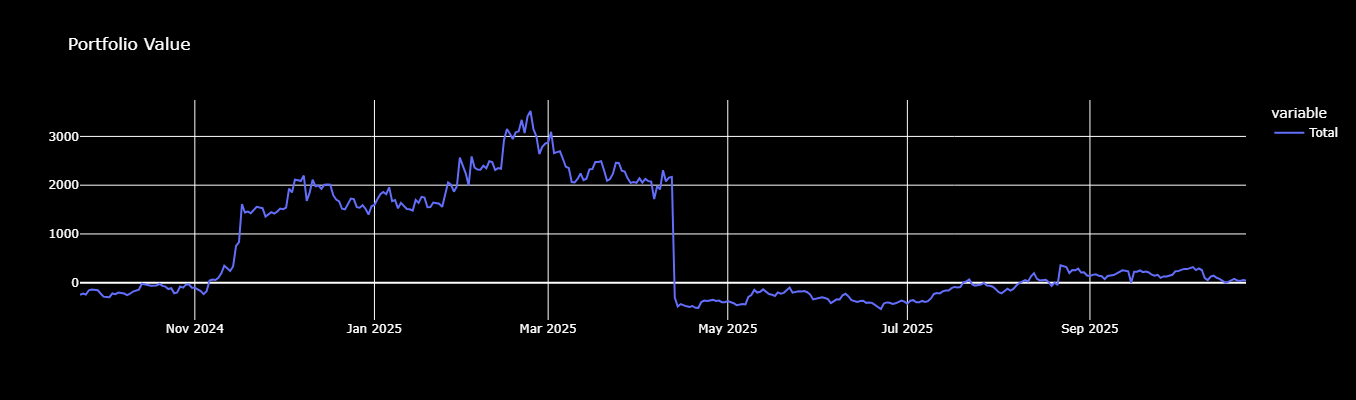

In [93]:
fig=px.line(pnl_history['Total'],title='Portfolio Value')
fig.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white",width=800, height=400)
fig.update_layout(xaxis_title=None, yaxis_title=None)
fig.show()

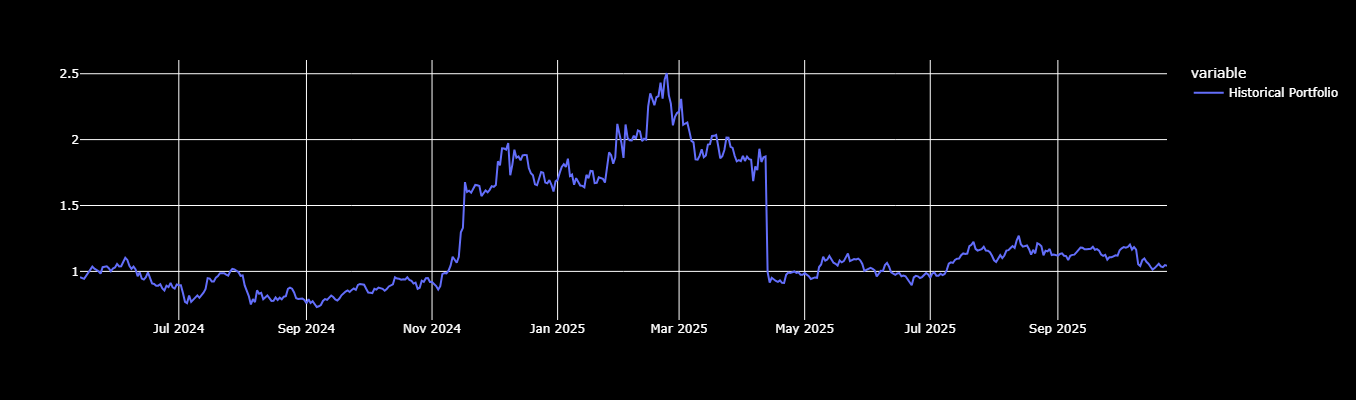

In [95]:
cumulative_performance_ex_post=(1+historical_ptf['Historical Portfolio']).cumprod()
fig=px.line(cumulative_performance_ex_post)
fig.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white",width=800, height=400)
fig.update_layout(xaxis_title=None, yaxis_title=None)
fig.show()

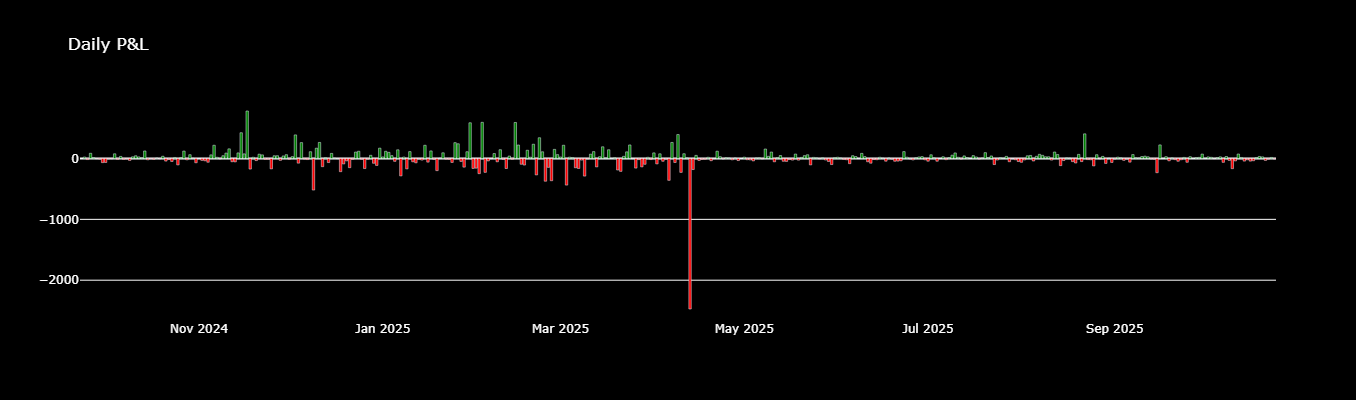

In [89]:
fig = px.bar(selected_daily_pnl, color=selected_daily_pnl['color'],
             color_discrete_map={'green': 'green', 'red': 'red'},
             title="Daily P&L")
fig.update_layout(plot_bgcolor="black", paper_bgcolor="black", font_color="white",width=800, height=400)
fig.update_layout(xaxis_title=None, yaxis_title=None,showlegend=False)
fig.show()

In [90]:
# realized_pnl_time=pd.DataFrame()

# for key in profit_and_loss:

#     temp=profit_and_loss[key]
#     realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

# realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

# realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

# realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
# realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
# realized_pnl_time.groupby(realized_pnl_time.index).sum()
# realized_pnl_time=realized_pnl_time.cumsum()
# realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
# realized_pnl_time_total=realized_pnl_time.sum(axis=1)

In [61]:
# weights_ex_post=positions.copy()
# weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
# weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

# start_date=weights_ex_post.index[0].date()

# days=(today-start_date).days

# remaining=days%500
# numbers_of_table=days//500
# remaining
# temp_end=weights_ex_post.index[0]
# prices=pd.DataFrame()
# for i in range(numbers_of_table+1):
#     temp_data=Binance.get_price(weights_ex_post.columns,temp_end)
#     temp_end=temp_end+datetime.timedelta(500)
#     prices=prices.combine_first(temp_data)
    
# temp_end=temp_end+datetime.timedelta(500)
# last_data=Binance.get_price(weights_ex_post.columns,temp_end)
# binance_data=prices.combine_first(last_data)
# binance_data=binance_data.sort_index()
# binance_data = binance_data[~binance_data.index.duplicated(keep='first')]
# binance_data.index=pd.to_datetime(binance_data.index)

In [ ]:
# git.create_or_replace_notebook("Crypto App.ipynb")